In [ ]:
!pip install mmcv-full

In [44]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 21092, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 21092 (delta 0), reused 3 (delta 0), pack-reused 21087
Receiving objects: 100% (21092/21092), 24.80 MiB | 39.19 MiB/s, done.
Resolving deltas: 100% (14745/14745), done.


In [ ]:
!python setup.py install

In [47]:
!mkdir checkpoints

In [48]:
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-09-30 05:25:15--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  9.29MB/s    in 18s     

2021-09-30 05:25:34 (8.97 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [1]:
!nvidia-smi

Thu Sep 30 06:09:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!mkdir /content/data

In [ ]:
!tar -xvf images.tar.gz -C /content/data/
!tar -xvf annotations.tar.gz -C /content/data/

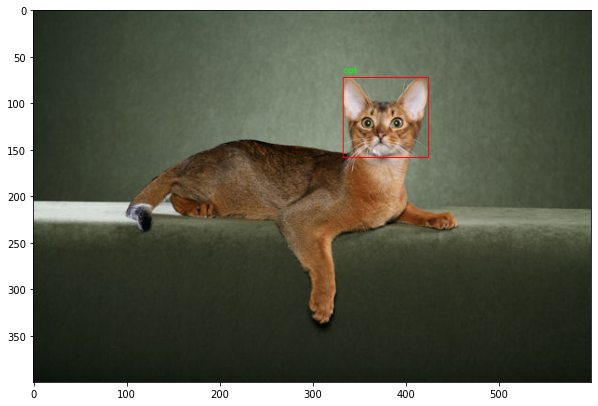

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
img_dir = "/content/data/images/"
xml_file = "/content/data/annotations/xmls/Abyssinian_1.xml"

tree = ET.parse(xml_file)
root = tree.getroot()

img_name = root.find('filename').text
img_size = root.find('size')
img_width = int(img_size.find('width').text)
img_height = int(img_size.find('height').text)

img_full_path = os.path.join(img_dir, img_name)
img = cv2.imread(img_full_path)
dst = img.copy()


objects = root.findall('object')
object_list = []

for obj in objects:
    box = obj.find("bndbox")
    x1 = int(box.find('xmin').text)
    y1 = int(box.find('ymin').text)
    x2 = int(box.find('xmax').text)
    y2 = int(box.find('ymax').text)

    bndbox_coor = (x1, y1, x2, y2)
    class_name = obj.find('name').text

    cv2.rectangle(dst, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=1)
    cv2.putText(dst, class_name, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), thickness=1 )

    object_dict = {'class_name' : class_name, 'bndbox_coor' : bndbox_coor}
    object_list.append(object_dict)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))


In [2]:
import pandas as pd
pet_df = pd.read_csv('./data/annotations/trainval.txt', sep=' ', header=None,
                     names=["image_name", "class_id", "dummy1", "dummy2" ])
pet_df

,image_name,class_id,dummy1,dummy2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
3675,yorkshire_terrier_187,37,2,25
3676,yorkshire_terrier_188,37,2,25
3677,yorkshire_terrier_189,37,2,25
3678,yorkshire_terrier_18,37,2,25


In [3]:
pet_df["class_id"].value_counts()

37    100
22    100
34    100
32    100
30    100
28    100
26    100
24    100
20    100
35    100
18    100
16    100
14    100
10    100
6     100
4     100
36    100
1     100
3     100
19    100
31    100
29    100
27    100
25    100
5     100
21    100
17    100
15    100
11    100
9     100
7     100
2     100
33     99
23     96
13     96
8      96
12     93
Name: class_id, dtype: int64

In [4]:
pet_df["class_name"] = pet_df["image_name"].apply(lambda x:x[:x.rfind('_')])

In [5]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(pet_df, test_size=0.1, stratify=pet_df["class_id"], random_state=42)

In [6]:
train_df.head()

,image_name,class_id,dummy1,dummy2,class_name
235,beagle_135,5,2,4,beagle
1633,Siamese_145,33,1,11,Siamese
2979,newfoundland_18,23,2,16,newfoundland
137,american_pit_bull_terrier_134,3,2,2,american_pit_bull_terrier
2454,english_cocker_spaniel_15,13,2,7,english_cocker_spaniel


In [7]:
train_df = train_df.sort_values(by="image_name")
val_df = val_df.sort_values(by="image_name")

In [8]:
train_df.head()

,image_name,class_id,dummy1,dummy2,class_name
10,Abyssinian_10,1,1,1,Abyssinian
0,Abyssinian_100,1,1,1,Abyssinian
1,Abyssinian_101,1,1,1,Abyssinian
2,Abyssinian_102,1,1,1,Abyssinian
3,Abyssinian_103,1,1,1,Abyssinian


In [9]:
train_df["image_name"].to_csv("./data/train.txt", sep=" ", header=False, index=False)
val_df["image_name"].to_csv("./data/val.txt", sep=" ", header=False, index=False)

In [10]:
pet_classes = pet_df["class_name"].unique().tolist()
len(pet_classes)

37

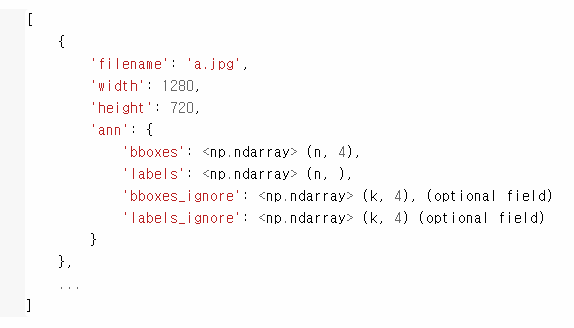

In [19]:
import xml.etree.ElementTree as ET
def get_bboxes(annor_dir, xml_file):
    anno_xml_file = os.path.join(annor_dir, xml_file)
    tree = ET.parse(anno_xml_file)
    root = tree.getroot()

    objects = root.findall('object')
    object_list = []

    bbox_names = []
    bboxes = []

    for obj in objects:

        bbox_name = xml_file[:xml_file.rfind('_')]

        box = obj.find("bndbox")
        x1 = int(box.find('xmin').text)
        y1 = int(box.find('ymin').text)
        x2 = int(box.find('xmax').text)
        y2 = int(box.find('ymax').text)

        bbox_names.append(bbox_name)
        bboxes.append([x1, y1, x2, y2])
    return bbox_names, bboxes


In [43]:
ls -la

total 792108
drwxr-xr-x 1 root root      4096 Sep 30 02:09 ./
drwxr-xr-x 1 root root      4096 Sep 30 01:36 ../
-rw-r--r-- 1 root root  19173078 Jun 30  2012 annotations.tar.gz
drwxr-xr-x 4 root root      4096 Sep 16 13:39 .config/
drwxr-xr-x 4 root root      4096 Sep 30 03:13 data/
-rw-r--r-- 1 root root 791918971 Jun 18  2012 images.tar.gz
drwxr-xr-x 1 root root      4096 Sep 16 13:40 sample_data/


In [12]:
import copy
import os.path as osp
import os

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module(force=True)
class PetDataset(CustomDataset):
    pet_classes = pet_df["class_name"].unique().tolist()
    CLASSES = pet_classes
    
    ### self.ann_file : /content/data/train.txt
    ### self.img_prefix : /content/data/images
    ### ann_file : /content/data/train.txt

    def load_annotations(self, ann_file):
        print("self.ann_file : ", self.ann_file)
        print("self.img_prefix: ", self.img_prefix)

        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('images', 'annotations')
            anno_xml_file = os.path.join(label_prefix, 'xmls/' + str(image_id) + '.xml')
            
            if not os.path.exists(anno_xml_file):
                continue
            
            anno_xml_dir = os.path.join(label_prefix, 'xmls')
            bbox_names, bboxes = get_bboxes(anno_xml_dir, str(image_id) + '.xml')


            #lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            #content = [line.strip().split(' ') for line in lines]
            #bbox_names = [x[0] for x in content]
            #bbox_names = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [13]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [14]:
from mmcv import Config
cfg = Config.fromfile(config_file)

In [15]:
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [35]:
from google.colab import drive
drive.mount(("/content/gdrive"))

Mounted at /content/gdrive


In [38]:
%pwd

'/content/mmdetection'

In [42]:
ls -la /content/gdrive/MyDrive

total 13
drwx------ 2 root root 4096 Mar 15  2021 'Colab Notebooks'/
lrw------- 1 root root   25 Sep 29 21:54 'My Drive' -> '/content/gdrive/My Drive/'/
drwx------ 2 root root 4096 Sep 30 07:52  pet_checkpoints/
drwx------ 2 root root 4096 Sep 29 21:37  pet_work_dir/


In [41]:
mkdir /content/gdrive/MyDrive/pet_checkpoints

In [31]:
ls -la ./tutorial_exps

total 324176
drwxr-xr-x  2 root root      4096 Sep 30 06:58 ./
drwxr-xr-x 20 root root      4096 Sep 30 06:08 ../
-rw-r--r--  1 root root 331735441 Sep 30 06:58 epoch_5.pth
lrwxrwxrwx  1 root root        11 Sep 30 06:58 latest.pth -> epoch_5.pth
-rw-r--r--  1 root root    197208 Sep 30 06:58 None.log.json


In [16]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'PetDataset'
cfg.data_root = '/content/data/'

cfg.data.test.type = 'PetDataset'
cfg.data.test.data_root = '/content/data/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'PetDataset'
cfg.data.train.data_root = '/content/data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PetDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 37
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'
#cfg.work_dir = "/content/gdrive/MyDrive/pet_checkpoints"

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 5

cfg.runner.max_epochs = 5

cfg.data.samples_per_gpu = 4

cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 5
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 5

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [17]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

In [20]:
datasets = [build_dataset(cfg.data.train)]

self.ann_file :  /content/data/train.txt
self.img_prefix:  /content/data/images


/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/datasets/custom.py:157: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [32]:
datasets

[
 PetDataset Train dataset with number of images 3303, and instance counts: 
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | category              | count | category                | count | category                      | count | category            | count | category                        | count |
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | 0 [Abyssinian]        | 89    | 1 [american_bulldog]    | 90    | 2 [american_pit_bull_terrier] | 90    | 3 [basset_hound]    | 90    | 4 [beagle]                      | 90    |
 | 5 [Bengal]            | 89    | 6 [Birman]              | 90    | 7 [Bombay]                    | 87    | 8 [boxer]           | 90    | 9 [British_Shorthair]           | 90    |
 | 10 [chihuahua]

In [21]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg') )
model.CLASSES = datasets[0].CLASSES

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [ ]:
%cd mmdetection/
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

In [23]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.17.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


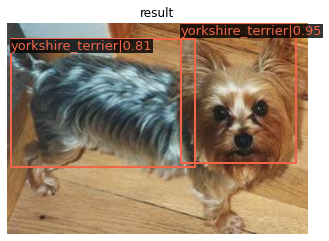

In [30]:
import cv2

img = cv2.imread("/content/data/images/yorkshire_terrier_138.jpg")

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.5)

In [ ]:
result